<a href="https://colab.research.google.com/github/zoegarm/Analisis_INE_2021/blob/main/Analsis_BD_INE_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import pandas as pd
import matplotlib .pyplot as plt
import seaborn as sns 
import numpy as np
from wordcloud import WordCloud
from nltk.util import ngrams
import re
import nltk
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
nltk.download('punkt')
nltk.download('stopwords')

sns.set_style('whitegrid')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
#cargo la "base de datos" del ine: 
ine = 'https://candidaturas.ine.mx/documentos/descargas/baseDatosCandidatos.xls'

df = pd.read_excel(ine)

In [25]:
#cambio los nombres de las columnas: 

names = list(df)
names[10] = 'DIRECCION' #direccion de la candidatura
names = [name.lower() for name in names]

#hago un diccionario para realizar un mapeo: 

mapa_nombres = {list(df)[i]:names[i] for i in range(len(names))}
mapa_nombres 

#remapo los nombres de las columnas: 

df = df.rename(columns= mapa_nombres)

#relleno los NaN con strings vacíos: 
df = df.fillna('')

#hag una columna extra para sacar el num de distrito y normalizar: 
df['distrito_num'] = df["distrito"].str.strip().str.split('-', expand = True).iloc[:, 0]

#también puedo dividir por representación proporcional (RP) y representación de mayoría relativa (MR) para intentar normalizar otro poquito la BD:

df['candidatura_tipo'] = df['candidatura'].str.strip().str.split(expand = True).iloc[:,2]

#saco solo los candidatos titulares (en este DF dejamos fuera a los suplentes)
df_propietarios = df[(df['tipo_candidato'] == 'PROPIETARIO')].reset_index(drop = True)

## candidatos actualmente registrados por tipo de candidatura:


- representación proporcional (RP)  
- representación de mayoría relativa (MR)

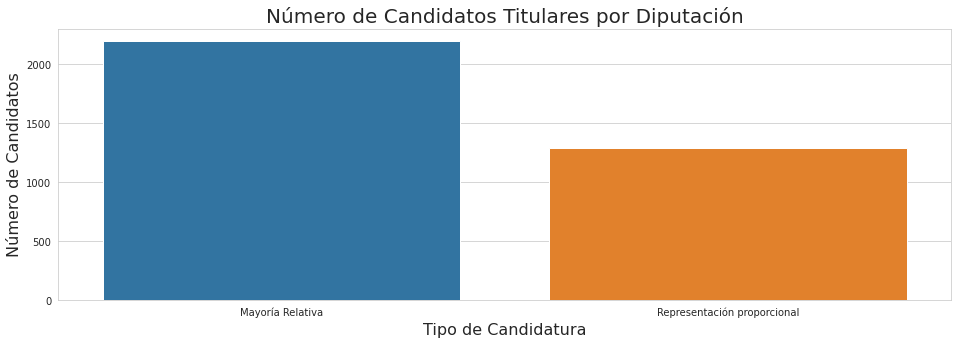

candidatura_tipo
MR    2191
RP    1290
Name: candidatura_tipo, dtype: int64


In [26]:
#cuento el número de candidatos titulares en cada tipo de candidatura: 

x = df_propietarios.groupby(['candidatura_tipo'])['candidatura_tipo'].agg('count')

plt.figure(figsize=(16,5))

sns.barplot(x = ['Mayoría Relativa', 'Representación proporcional'], y = x)

plt.title('Número de Candidatos Titulares por Diputación', fontsize = 20)

plt.xlabel('Tipo de Candidatura', fontsize = 16)
plt.ylabel('Número de Candidatos', fontsize = 16)

plt.show()

print(x)

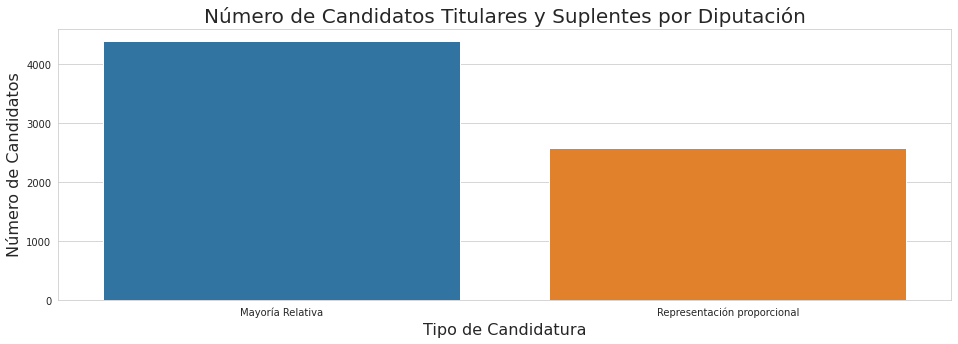

In [27]:
x = df.groupby(['candidatura_tipo'])['candidatura_tipo'].agg('count')

plt.figure(figsize=(16,5))

sns.barplot(x = ['Mayoría Relativa', 'Representación proporcional'], y = x)

plt.title('Número de Candidatos Titulares y Suplentes por Diputación', fontsize = 20)

plt.xlabel('Tipo de Candidatura', fontsize = 16)
plt.ylabel('Número de Candidatos', fontsize = 16)

plt.show()

## Analisis de las propuestas: 

Algo que debería de importarnos como ciudadanos a la hora de elegir un candidato a diputación son las propuestas que tienen estos candidatos. Si bien, es cierto que no podemos conocer TODAS las propuestas de los candidatos, al menos podemos conocer las propuestas registradas cuando entraron a la base de datos del INE. 

Algo que quisiera conocer es cuál es el tipo de propuesta "más popular" y analizar el enfoque que tienen las acutales campañas políticas, esto lo podemos hacer por región. 

In [28]:
df_propietarios['entidad'].unique()

array(['AGUASCALIENTES', 'BAJA CALIFORNIA', 'BAJA CALIFORNIA SUR',
       'CAMPECHE', 'CHIAPAS', 'CHIHUAHUA', 'CIUDAD DE MÉXICO', 'COAHUILA',
       'COLIMA', 'DURANGO', 'GUANAJUATO', 'GUERRERO', 'HIDALGO',
       'JALISCO', 'MÉXICO', 'MICHOACÁN', 'MORELOS', 'NAYARIT',
       'NUEVO LEÓN', 'OAXACA', 'PUEBLA', 'QUERÉTARO', 'QUINTANA ROO',
       'SAN LUIS POTOSÍ', 'SINALOA', 'SONORA', 'TABASCO', 'TAMAULIPAS',
       'TLAXCALA', 'VERACRUZ', 'YUCATÁN', 'ZACATECAS', 'NACIONAL'],
      dtype=object)

In [29]:
#hago una columna que contenga todas las prupuestas de cada candidato: 
df_propietarios['propuestas_general'] = df_propietarios['propuesta_1'].astype(str) + df_propietarios['propuesta_2'].astype(str) + df['propuesta_genero'].astype(str)

In [30]:
propuestas_group = df_propietarios.groupby(['nombre_candidato', 'entidad', 'distrito_num', 'partido_coalicion'])['propuestas_general'].max().reset_index()

In [31]:
propuestas_group

,nombre_candidato,entidad,distrito_num,partido_coalicion,propuestas_general
0,AARON ANDRES DELGADO MARTINEZ,NACIONAL,,PARTIDO ENCUENTRO SOLIDARIO,Presentaré una iniciativa para que sea creada ...
1,AARON JIMENEZ HERNANDEZ,HIDALGO,4,FUERZA POR MÉXICO,Proteger al medio ambiente y proporcionar una ...
2,ABEL FIERRO APAC,NUEVO LEÓN,11,FUERZA POR MÉXICO,"Luchar a favor de la equidad de género, crear ..."
3,ABEL ROLANDO ESPINOSA FERRA,NACIONAL,,PARTIDO VERDE ECOLOGISTA DE MÉXICO,Vales de alimentos. Creación de un vale para q...
4,ABIGAIL ANGEL ORTEGA,NACIONAL,,PARTIDO REVOLUCIONARIO INSTITUCIONAL,Tipificación de transfeminicidios \r\nApertura...
...,...,...,...,...,...
3476,ZOE TAMAR INFANTE JIMENEZ,MICHOACÁN,10,FUERZA POR MÉXICO,En el marco de la nueva justicia penal acusato...
3477,ZONIA JUDITH MERINO GARCIA DE ALBA,JALISCO,8,PARTIDO ENCUENTRO SOLIDARIO,GENERACION DE MAYORES EMPLEOSDEFENDER A LA VIDA
3478,ZORAIDA CARDONA JIMENEZ,GUANAJUATO,7,MORENA,Apoyo para que ciudadanos y diferentes sectore...
3479,ZULEMA ALEJANDRA ALVARADO GARCIA,COAHUILA,6,MOVIMIENTO CIUDADANO,"Agua tratada, trabajar de la mano con el munic..."


In [32]:
# Defino una clase para poder manipular información de manera cómoda: 
class info_propuestas_entidad(pd.DataFrame):
  def __init__(self, entidad = None, distrito = None, *args, **kwargs):
    pd.DataFrame.__init__(self, *args, **kwargs)
    self.entidad  = entidad
    self.distrito = distrito

  def propuestas_entidad(self, to_csv = False, *args, **kwargs): 
        #filtro para los candidatos de cada entidad: 
    if type(self.distrito) == int:
      propuestas_prop  = propuestas_group[(propuestas_group['entidad'] == f'{self.entidad}') & (propuestas_group['distrito_num'] == str(self.distrito))].groupby(['nombre_candidato', 'partido_coalicion'])['propuestas_general'].max().reset_index()
    else:
      propuestas_prop  = propuestas_group[propuestas_group['entidad'] == f'{self.entidad}'].groupby(['nombre_candidato', 'partido_coalicion'])['propuestas_general'].max().reset_index()

    if to_csv == True: 
      csv = pd.DataFrame.to_csv(propuestas_prop, f'propuestas_{self.entidad}_{self.distrito}.csv', *args, **kwargs)
      return csv

    else:
      return propuestas_prop

  def filtros(self):

    #filtro para los candidatos de cada entidad: 
    if type(self.distrito) == int:
      propuestas_prop  = propuestas_group[(propuestas_group['entidad'] == f'{self.entidad}') & (propuestas_group['distrito_num'] == str(self.distrito))].groupby('nombre_candidato')['propuestas_general'].max()
    else:
      propuestas_prop  = propuestas_group[propuestas_group['entidad'] == f'{self.entidad}'].groupby('nombre_candidato')['propuestas_general'].max()

    #Hago una limpieza de los elementos: 

    propuestas_prop = propuestas_prop.str.lower()
    propuestas_prop = propuestas_prop.str.strip()
    propuestas_prop = propuestas_prop.str.replace('[^\w\s]', '')
    propuestas_prop = propuestas_prop.str.replace('\d', '')
    propuestas_prop = propuestas_prop.str.replace('\\n', '')
    propuestas_prop = propuestas_prop.dropna()

    #Separo las oraciones en palabras

    #ahora separo las oraciones en palabras: 

    tokenized = propuestas_prop.apply(nltk.word_tokenize)

    all_words = tokenized.sum()

    # Utilizamos FreqDist para analizar la distribución de frecuencia de nuestras palabras

    freq_dist = nltk.FreqDist(all_words)

    #quito los conectores o stopwords: 

    spanish_stop_words = stopwords.words('spanish')
    spanish_stop_words.append('así') #anexo este conector

    all_words_except_stop_words = [word for word in all_words if word not in spanish_stop_words]

    #filtro las palabras:
    freq_dist = nltk.FreqDist(all_words_except_stop_words)

    return freq_dist, all_words_except_stop_words, all_words

  def grafica_nube_palabras(self): 
    """ Regresa una nube de palabras con las principales propuestas realizadas en esa entidad """

    freq_dist, all_words_except_stop_words, all_words = self.filtros()

    plt.figure(figsize=(20,20), facecolor='white')
    wordcloud = WordCloud(width=1000, height=500, max_font_size=100, background_color="white", mode = "RGB").generate(' '.join(all_words_except_stop_words))

    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.margins(x=0, y=0)

    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.margins(x=0, y=0)


    plt.show()

  def grafica_palabras_comunes(self, num = 20): 
    """ Regresa una grafica de barras con las palabras más populares por entidad """

    freq_dist, all_words_except_stop_words, all_words = self.filtros()
    most_common_20 = np.array(list(map(lambda x: list(x), freq_dist.most_common(num))))

    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot()

    sns.barplot(y = most_common_20[:, 0], x = (most_common_20[:, 1]).astype(int), ax=ax, palette='RdYlBu', orient = 'h');
    ax.set_title(f'Frecuencia de las {num} palabras más comunes en las propuestas de los candidatos', fontsize = 20)
    ax.set_xlabel('Conteo de aparición por palabra', fontsize = 15)
    ax.tick_params(axis='x')

    plt.show()


  def grafica_ngramas_comunes(self, ngrama = 2, numero = 20): 
    """regresa una gráfica con los n-gramas más comunes de las propuestas"""  

    freq_dist, all_words_except_stop_words, all_words = self.filtros()


    text = nltk.Text(all_words_except_stop_words)
    freq_dist_trigrams = nltk.FreqDist(list(ngrams(text, ngrama)))

    most_common_20 = np.array(list(map(lambda x: list(x), freq_dist_trigrams.most_common(numero))))

    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot()

    sns.barplot(y = most_common_20[:, 0], x = (most_common_20[:, 1]).astype(int), ax=ax, palette='RdYlBu', orient='h');
    ax.set_title(f'Frecuencia de las {numero} {ngrama}-gramas más comunes sin conectores', pad=10, fontsize = 20)
    ax.set_xlabel(f'Conteo de las {ngrama}-gramas más frecuentes', fontsize = 15)
    ax.tick_params(axis='x')

    plt.show()

Realizo una prueba de la clase que realicé: 

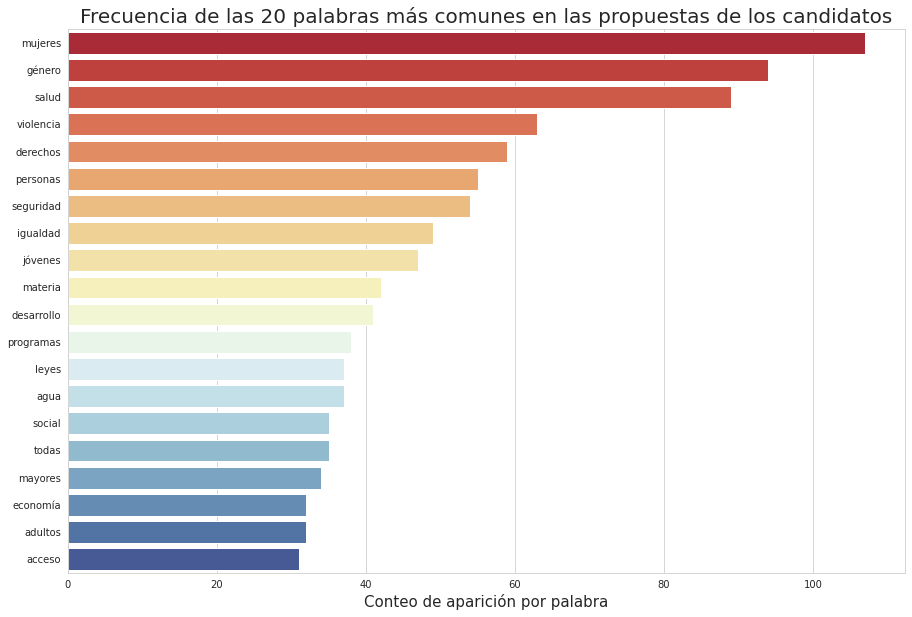

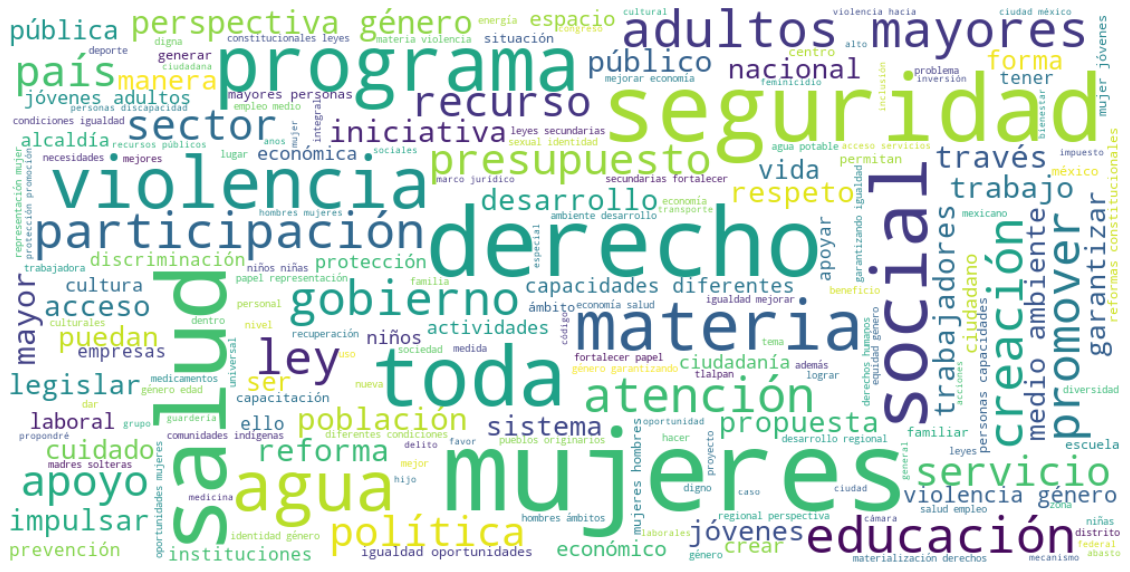

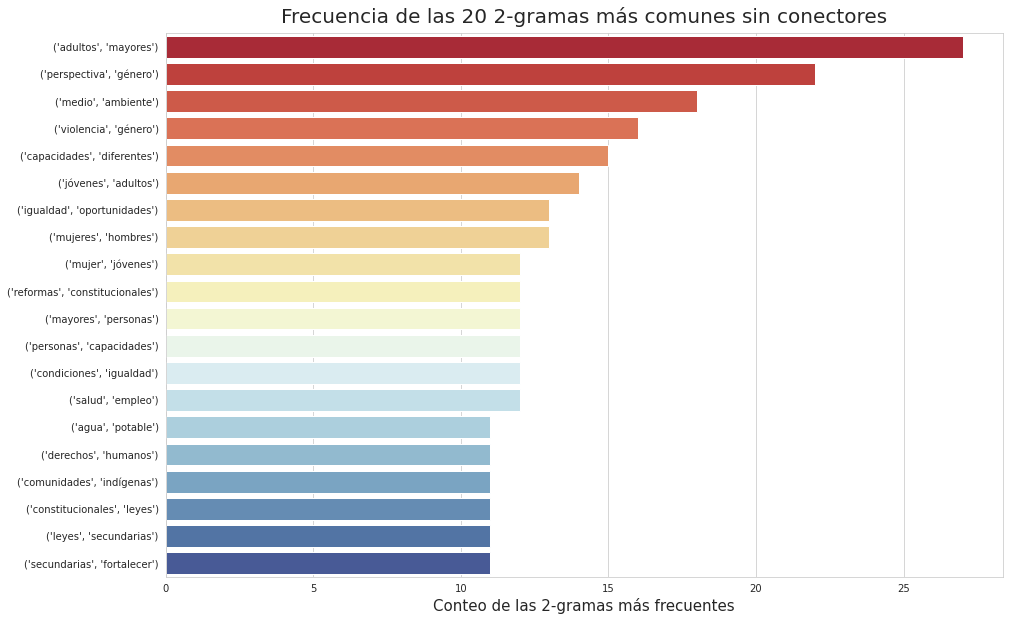

In [34]:
#para la CDMX: 

CDMX = info_propuestas_entidad('CIUDAD DE MÉXICO')
CDMX.grafica_palabras_comunes()
CDMX.grafica_nube_palabras()
CDMX.grafica_ngramas_comunes()

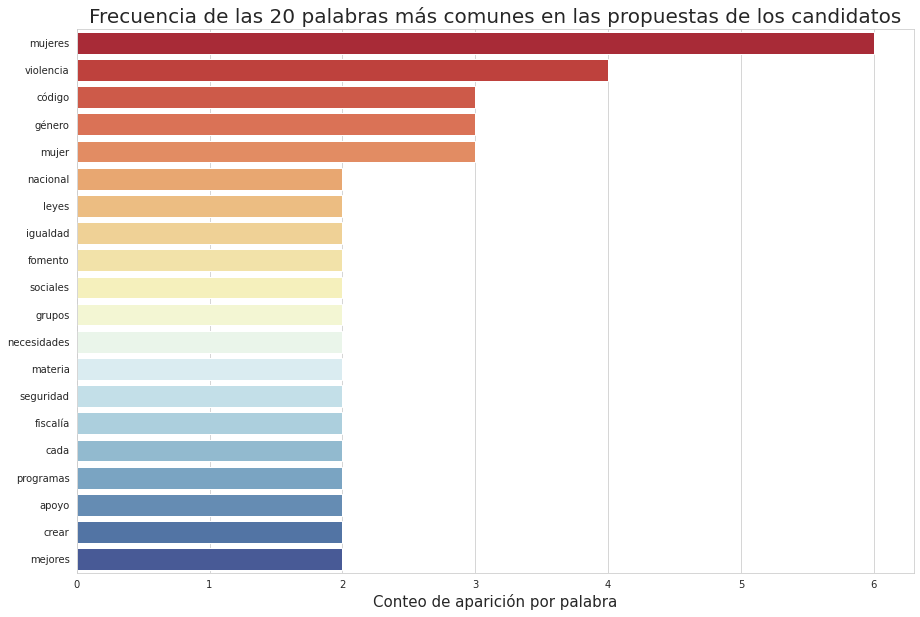

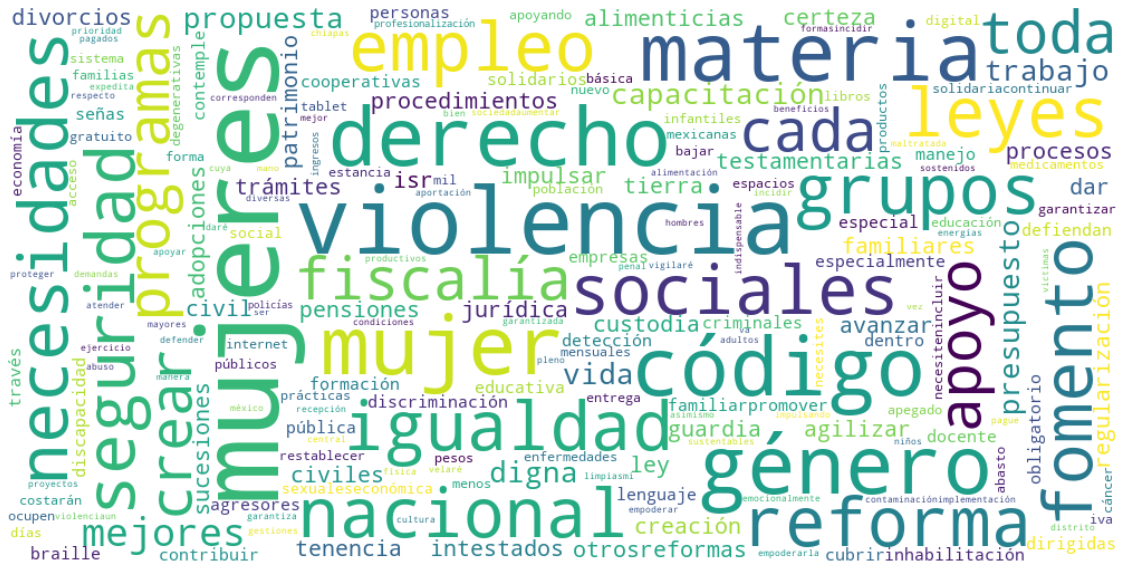

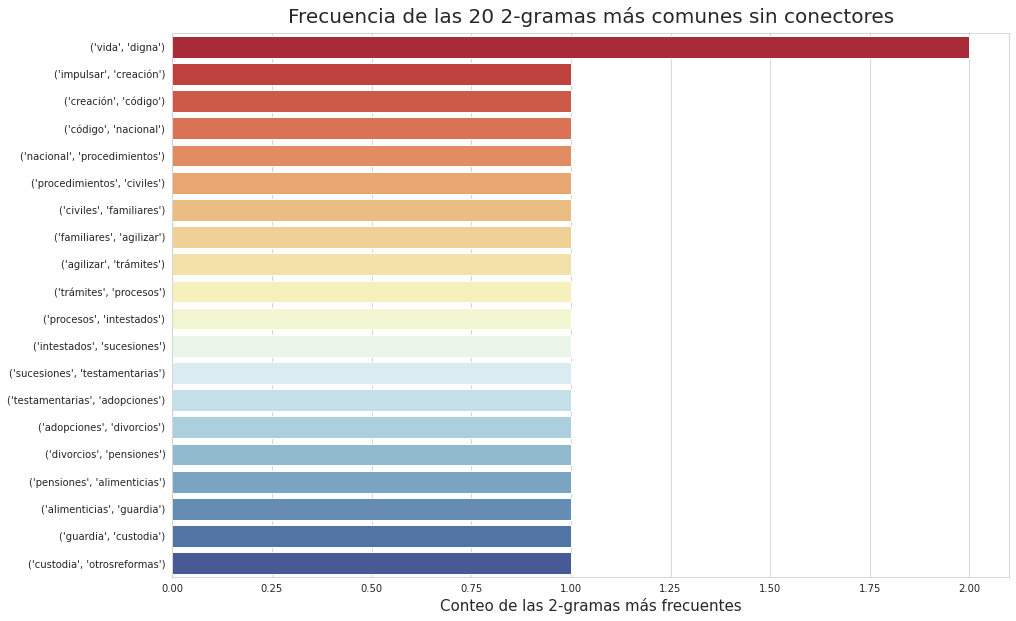

In [35]:
#para la CDMX Distrito 19: 

CDMX_19 = info_propuestas_entidad('CIUDAD DE MÉXICO', distrito=19)
CDMX_19.grafica_palabras_comunes()
CDMX_19.grafica_nube_palabras()
CDMX_19.grafica_ngramas_comunes()